In [1]:
import signal

class TimeOut:
    """force timing out for things that get stuck"""
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message

    def handle_timeout(self, signum, frame):
        """handle timeout"""
        raise TimeoutError(self.error_message)

    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)

    def __exit__(self, type, value, traceback):
        signal.alarm(0)

# Extract pole-like street furniture

In this notebook we demonstrate how we can extract pole-like objects form labeled point clouds.

In this code we assume the point clouds have been labelled following the process in our [Urban PointCloud Processing](https://github.com/Amsterdam-AI-Team/Urban_PointCloud_Processing/tree/main/datasets) project. For more information on the specifics of the datasets used, see [the description there](https://github.com/Amsterdam-AI-Team/Urban_PointCloud_Processing/blob/main/datasets/README.md).

In [2]:
# Add project src to path.
import set_path

import numpy as np
import pandas as pd
import os
import pathlib
import laspy
from tqdm import tqdm

#from upcp.labels import Labels 
from labels import Labels
from upcp.utils import las_utils
from upcp.utils import ahn_utils
import upcp.utils.bgt_utils as bgt_utils
from upc_analysis import PoleExtractor 
from upc_analysis import visualization 

In [3]:
base_folder = '../../../code/blobfuse/ovl'

# We provide some example data for demonstration purposes.
dataset_folder = f'{base_folder}/pointcloud/'
prefix = 'final_'
files = list(pathlib.Path(dataset_folder).glob(f'{prefix}*.laz'))

# Define the class we are interested in
target_label = 60  

# Labels used for ground points ('Road' and 'Other ground')
ground_labels = [1, 9]

# AHN data reader for elevation data. This is optional: the data is only used when
# the ground elevation cannot be determined from the labeled point cloud itself.
ahn_data_folder = f'{base_folder}/ahn/'
ahn_reader = ahn_utils.NPZReader(ahn_data_folder, caching=False)

# BGT data reader for building shapes. This is optional: the data is used to check
# whether an extracted object is located within a building footprint. This might
# indicate a false positive.
# If an appropriate dataset is available, uncomment these lines to use it:
if os.path.exists(f'{base_folder}/bgt/bgt_buildings_oost.csv'):
    bgt_building_file = f'{base_folder}/bgt/bgt_buildings_oost.csv'
    bld_reader = bgt_utils.BGTPolyReader(bgt_building_file)
else:
    bld_reader = None

In [4]:
# Settings for noise filtering
EPS_N = 0.4
MIN_SAMPLES_N = 10

# Settings for clustering
EPS = 1
MIN_SAMPLES = 200

In [5]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

my_settings = str(MIN_SAMPLES_N) + '_' + str(int(EPS_N*10)) + '_' + str(MIN_SAMPLES) + '_' + str(int(EPS*10))
output_file = f'{base_folder}/{timestr}_poles_extracted_' + my_settings + '.csv'

---
## Extracting pole-like objects

This method works by clustering points of a given target class, and then using statistics and PCA analysis on each cluster to determine the exact pole.

The result is a dataset with the following features for each extracted object:
```txt
rd_x, rd_y, z = X, Y, Z coordinates of the base of the pole
tx, ty, tz    = X, Y, Z coordinates of the top of the pole
height        = the height of the pole, in m
angle         = the angle of the pole, in degrees w.r.t. vertical
prob          = the average probability of the classification, if this data is available in the point cloud
n_points      = the number of points of the object
in_bld        = flag that indicates whether the object is located inside a building footprint
debug         = debug code, see below
tilecode      = tilecode in which the object was found
```
The debug code `A_B` indicates potential issues with either the ground elevation (A) or the pole extraction (B). A can be either 0 (no problems), 1 (no ground elevation found in the point cloud), or 2 (no ground elevation found in AHN). B can be either 0 (no problems), 3 (not enough data to determine the angle), or 4 (not enough data to determine the exact location).

In [6]:
# Create PoleExtractor object
pole_extractor = PoleExtractor(target_label, ground_labels,
                               ahn_reader=ahn_reader, building_reader=bld_reader,
                               eps_noise=EPS_N, min_samples_noise=MIN_SAMPLES_N,
                               eps=EPS, min_samples=MIN_SAMPLES)   

In [7]:
# Loop over point cloud files and extract objects
locations = []
for file in tqdm(files):
    try:
        with TimeOut(240):
            tilecode = las_utils.get_tilecode_from_filename(file.as_posix())
            pc = laspy.read(file)
            labels = pc.final_label
            if 'probability' in pc.point_format.extra_dimension_names:
                probabilities = pc.probability
            else:
                probabilities = np.zeros_like(labels)

            if np.count_nonzero(labels == target_label) > 0:
                points = np.vstack((pc.x, pc.y, pc.z)).T
                tile_locations = pole_extractor.get_pole_locations(points, labels, probabilities, tilecode)
                locations.extend([(*x, tilecode) for x in tile_locations])
    except:
        continue

HEADERS = ['rd_x', 'rd_y', 'z', 'tx', 'ty', 'tz', 'height', 'angle', 'prob', 'n_points', 'in_bld', 'debug', 'tilecode']
poles_df = pd.DataFrame(locations, columns=HEADERS)

100%|██████████| 52/52 [55:49<00:00, 64.41s/it]   


42926
6118
38793
4424
24531
6344
1338
45362
190468
15712
2242
35317
4953
7450
1430
29499
4436
39499
5630
40977
4164
8705
1644
11905
1901
16538
2573
16466
3717
14165
4147
12342
1674
55840
10506
21514
4087
52475
8616
51821
9854
70078
9861
34046
4565
31075
5119
34617
4520
65799
9542
20011
2322
37047
4615
31271
4391
46060
3558
81186
7555
2109
94688
50101
5279
17456
2783
6050
1036
7009
1959
26459
3003
50451
5426
10211
1143
44993
5355
4146
1105
66616
9955
22814
4558
15711
2899
27002
5815
9301
1032
1088
408
37588
5851
21776
2706
9456
2038


In [11]:
poles_df.head(2)

,rd_x,rd_y,z,tx,ty,tz,height,angle,prob,n_points,in_bld,debug,tilecode
0,122269.95,485540.26,0.78,122269.75,485540.25,4.94,4.17,2.80,0.0,415,0,0_0,2445_9710
1,122274.23,485540.00,0.62,122274.64,485540.13,9.89,9.28,2.63,0.0,817,0,0_0,2445_9710
2,122276.18,485540.40,0.58,122276.01,485540.18,9.83,9.26,1.71,0.0,1360,0,0_0,2445_9710
3,122287.37,485543.31,2.06,122282.37,485541.93,9.72,9.25,34.13,0.0,242,0,0_0,2445_9710
4,122283.59,485542.21,0.57,122283.68,485542.27,9.09,8.51,0.71,0.0,1052,0,0_0,2445_9710


In [12]:
# Save the data in CSV format.
poles_df.to_csv(output_file, index=False)

---
## Visualize extracted poles

In order to verify the results and spot potential issues, we can visualize individual objects. The visualization renders the object from two directions (X and Y axis), along with a 3D projection.

In [13]:
# Optional: load data from CSV.
poles_df = pd.read_csv(output_file)

In [14]:
len(poles_df)

278

#### Loop over all poles

In [15]:
%matplotlib inline

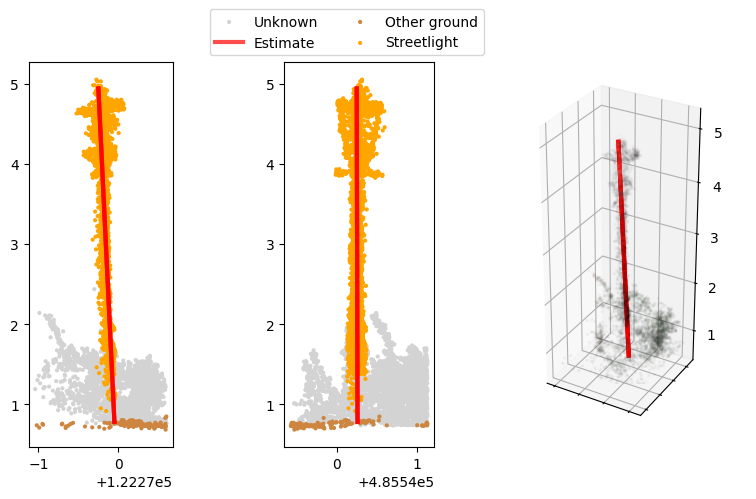

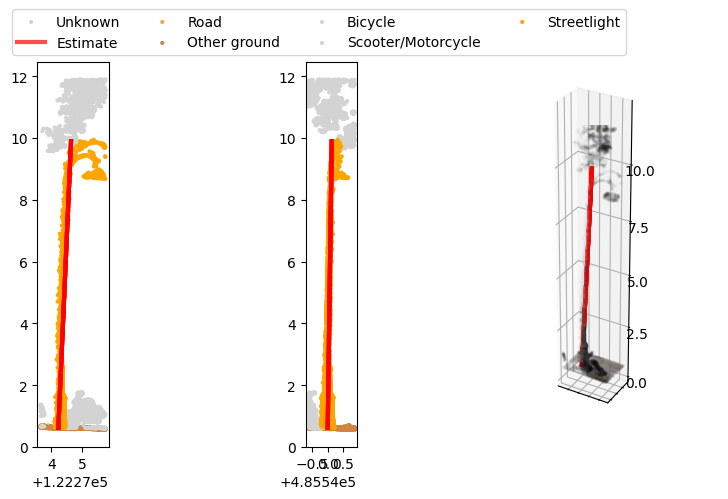

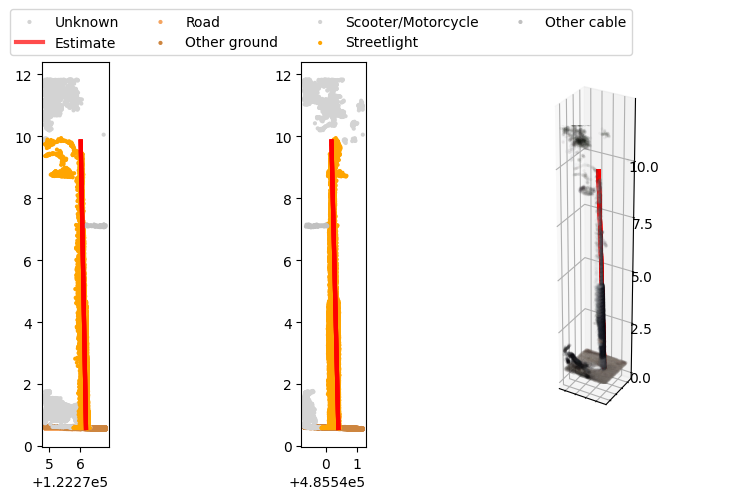

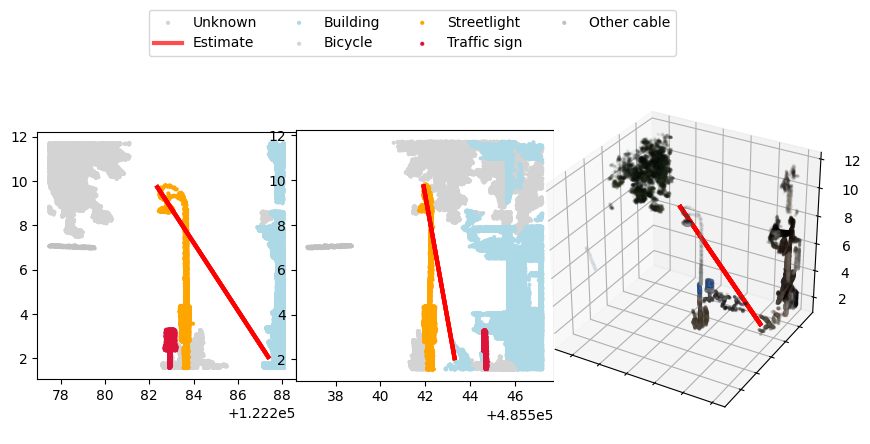

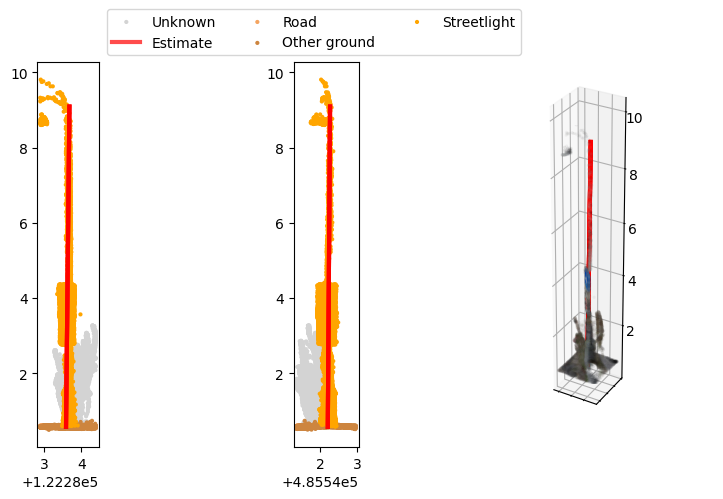

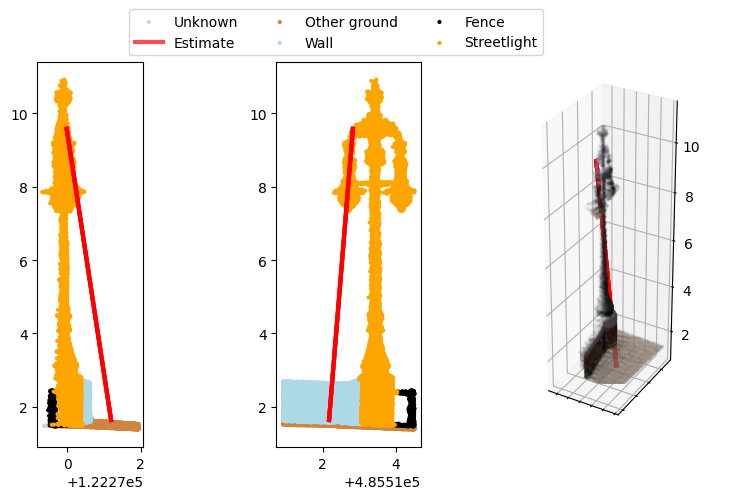

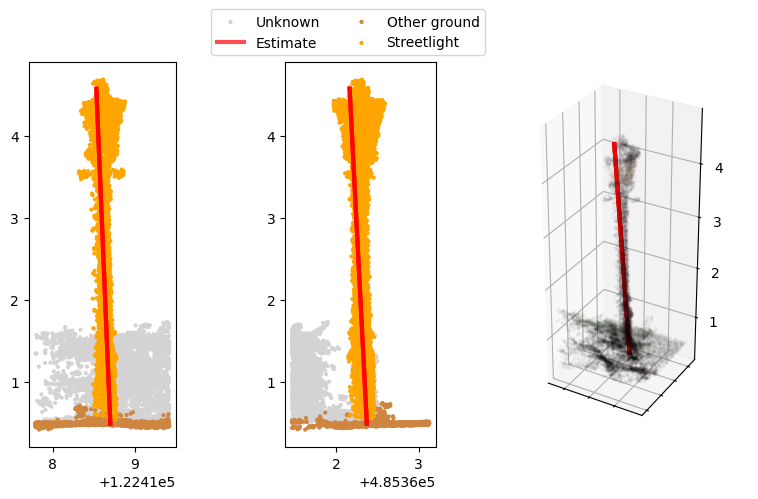

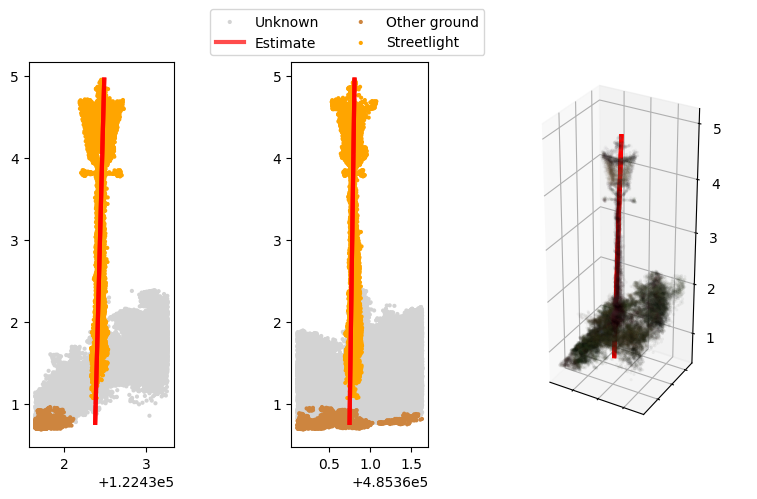

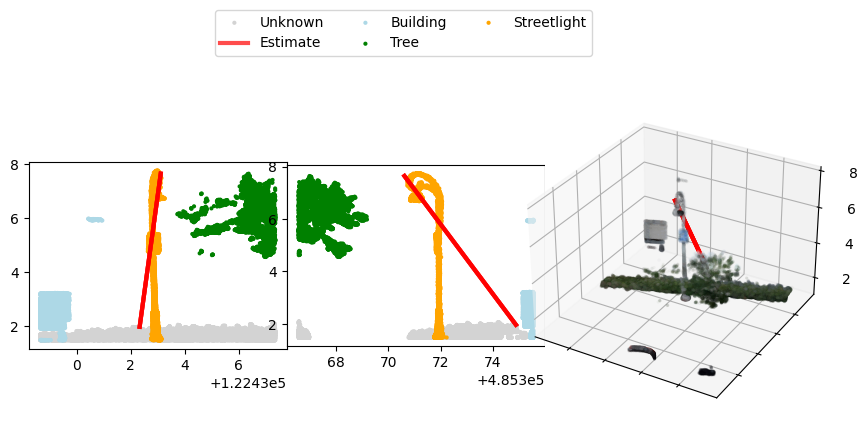

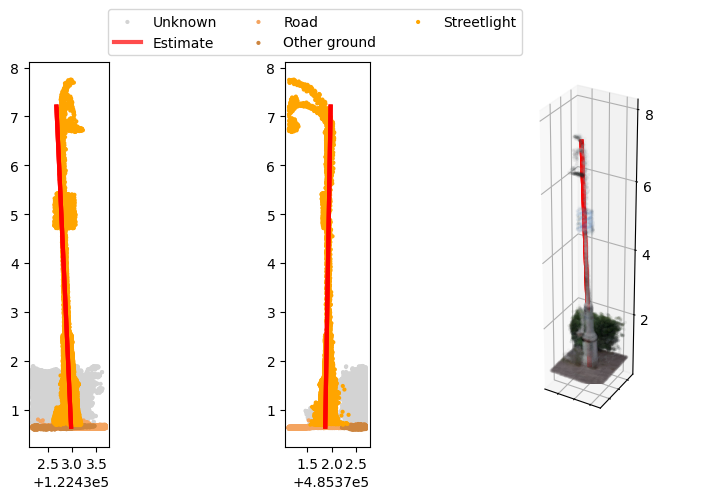

In [16]:
for row_id in range(0, len(poles_df)): 
    # Get the object features
    obj = poles_df.loc[row_id]
    obj_location = (obj.rd_x, obj.rd_y, obj.z)
    obj_top = (obj.tx, obj.ty, obj.tz)

    # Load the point cloud data for the tile containing this object
    cloud = laspy.read(f'{dataset_folder}{prefix}{obj.tilecode}.laz')
    points = np.vstack((cloud.x, cloud.y, cloud.z)).T
    labels = cloud.final_label
    colors = np.vstack((cloud.red, cloud.green, cloud.blue)).T / (2**16 - 1)

    # Get a mask for the point cloud around the object's location
    obj_mask = visualization.get_mask_for_obj(points, labels, target_label, obj_location, obj_top[2],
                                              obj_angle=obj.angle, noise_filter=True,
                                              eps_noise=EPS_N, min_samples_noise=MIN_SAMPLES_N,
                                              eps=EPS, min_samples=MIN_SAMPLES)
    
    # Create path to store output image
    output_path = f'{base_folder}/{timestr}_output_image_' + my_settings + '_' + str(row_id) + '.png'

    # Show the object and store
    visualization.plot_object(points[obj_mask], labels[obj_mask], colors=colors[obj_mask],
                              estimate=np.vstack((obj_location, obj_top)), output_path=output_path)

#### Look at one pole

In [17]:
# Either choose a row number of sample one randomly
row_id = 0
# idx = np.random.randint(0, len(poles_df))
# row_id = poles_df.index[idx]

# Get the object features
obj = poles_df.loc[row_id]
obj_location = (obj.rd_x, obj.rd_y, obj.z)
obj_top = (obj.tx, obj.ty, obj.tz)

# Let's see the object in question
poles_df.loc[[row_id]]

,rd_x,rd_y,z,tx,ty,tz,height,angle,prob,n_points,in_bld,debug,tilecode
0,122269.95,485540.26,0.78,122269.75,485540.25,4.94,4.17,2.8,0.0,415,0,0_0,2445_9710


In [19]:
# Load the point cloud data for the tile containing this object
cloud = laspy.read(f'{dataset_folder}{prefix}{obj.tilecode}.laz')
points = np.vstack((cloud.x, cloud.y, cloud.z)).T
labels = cloud.final_label
colors = np.vstack((cloud.red, cloud.green, cloud.blue)).T / (2**16 - 1)

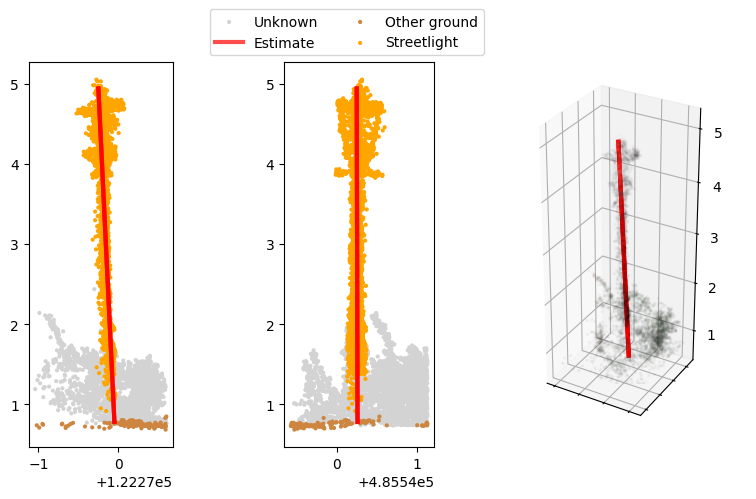

In [20]:
# Get a mask for the point cloud around the object's location
obj_mask = visualization.get_mask_for_obj(points, labels, target_label, obj_location, obj_top[2],
                                          obj_angle=obj.angle, noise_filter=True,
                                          eps_noise=EPS_N, min_samples_noise=MIN_SAMPLES_N,
                                          eps=EPS, min_samples=MIN_SAMPLES)

# Create path to store output image
output_path = f'{base_folder}/{timestr}_output_image_' + my_settings + '_' + str(row_id) + '.png'

# Show the object and store
visualization.plot_object(points[obj_mask], labels[obj_mask], colors=colors[obj_mask],
                          estimate=np.vstack((obj_location, obj_top)), output_path=output_path)

In [23]:
# Print location (to be pasted in Google Maps)
import geopandas as gpd
import shapely.geometry as sg
my_lon = float(poles_df.loc[[row_id]]['rd_x'])
my_lat = float(poles_df.loc[[row_id]]['rd_y'])
df_loc = gpd.GeoDataFrame({'geometry': [sg.Point(my_lon, my_lat)]}, crs='epsg:28992').to_crs("epsg:4326") 
print(float(df_loc['geometry'].y), float(df_loc['geometry'].x))

52.35678420901844 4.906759310314881
